In [2]:
import numpy as np
import torch
import utils
import models
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import importlib
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


# Linear Regression

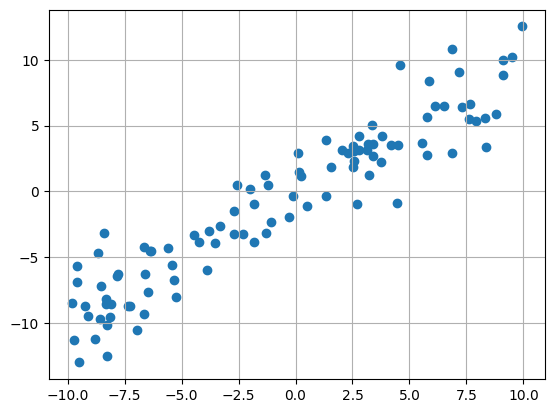

In [2]:
linear_data = utils.generate_noisy_data(utils.linear, datapoints= 100, std = 2, m = 1, b = 0)
linear_loader = DataLoader(utils.ToyDataset(*linear_data))

valid_linear_data = utils.generate_noisy_data(utils.linear, datapoints= 20, std = 2, m = 1, b = 0)
valid_linear_loader = DataLoader(utils.ToyDataset(*valid_linear_data))

plt.scatter(*linear_data)
plt.grid()
plt.show()

In [3]:
mlp = models.MLP(input_dim= 1, output_dim= 1, hidden_dim = 8, depth= 2, task = 'regression')
print(mlp)

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (accuracy): MeanSquaredError()
)


In [4]:
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True)
# trainer = pl.Trainer(callbacks=[early_stop_callback])

trainer = pl.Trainer(max_epochs=10)
trainer.fit(mlp, linear_loader, valid_linear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 292.27it/s, v_num=34, val_loss=4.360, valid_acc=nan.0, train_loss=4.470]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 288.91it/s, v_num=34, val_loss=4.360, valid_acc=nan.0, train_loss=4.470]


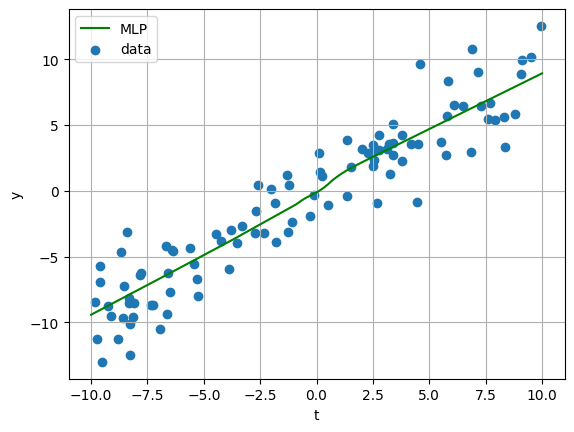

In [5]:
def show_preds(model, name, data = linear_data):
    ts = torch.linspace(-10, 10, 100)

    with torch.no_grad():
        preds = model(torch.unsqueeze(ts, dim = 1))

    plt.plot(ts.numpy(), preds.numpy(), 'g', label = name)

    plt.scatter(*data, label = 'data')
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.show()

show_preds(mlp, 'MLP')

In [6]:
asym_mlp = models.asymMLP(input_dim= 1, output_dim= 1, hidden_dim = 8, depth= 2, task = 'regression')
trainer2 = pl.Trainer(max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer2.fit(asym_mlp, linear_loader, valid_linear_loader)


  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 245.24it/s, v_num=35, val_loss=38.60, valid_acc=nan.0, train_loss=21.10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 242.42it/s, v_num=35, val_loss=38.60, valid_acc=nan.0, train_loss=21.10]


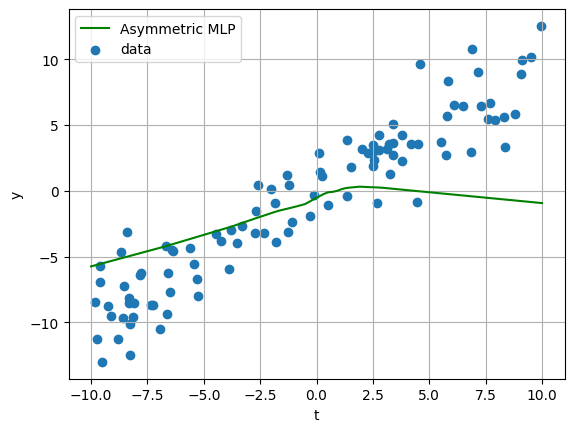

In [8]:
show_preds(asym_mlp, name = 'Asymmetric MLP')

In [9]:
trainer3 = pl.Trainer(max_epochs=100)
trainer3.fit(asym_mlp, linear_loader, valid_linear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 293.05it/s, v_num=36, val_loss=9.810, valid_acc=nan.0, train_loss=5.900]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 290.32it/s, v_num=36, val_loss=9.810, valid_acc=nan.0, train_loss=5.900]


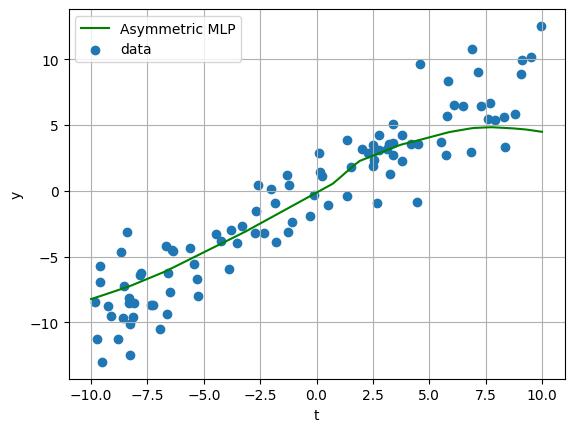

In [10]:
show_preds(asym_mlp, name = 'Asymmetric MLP')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 100/100 [00:00<00:00, 242.73it/s, v_num=38, val_loss=5.260, valid_acc=nan.0, train_loss=4.520]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 100/100 [00:00<00:00, 240.40it/s, v_num=38, val_loss=5.260, valid_acc=nan.0, train_loss=4.520]


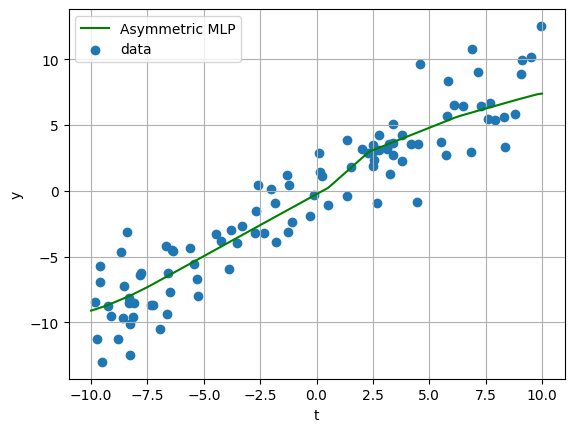

In [12]:
trainer3 = pl.Trainer(max_epochs=300)
trainer3.fit(asym_mlp, linear_loader, valid_linear_loader)
show_preds(asym_mlp, name = 'Asymmetric MLP')

# Learning another function

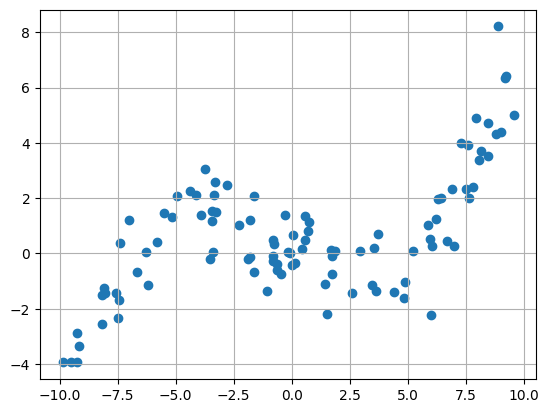

In [10]:
f_mlp = models.MLP(input_dim=1, output_dim=1, hidden_dim=8, depth=2, task='regression')

def poly(x):
    return 0.01*(x-1)*(x-5)*(x+7)

nonlinear_data = utils.generate_noisy_data(poly, datapoints= 100, std = 1)
nonlinear_loader = DataLoader(utils.ToyDataset(*nonlinear_data))

valid_nonlinear_data = utils.generate_noisy_data(poly, datapoints= 20, std = 1)
valid_nonlinear_loader = DataLoader(utils.ToyDataset(*valid_nonlinear_data))

plt.scatter(*nonlinear_data)
plt.grid()
plt.show()

In [12]:
def show_preds(model, name, data):
    ts = torch.linspace(-10, 10, 100)

    with torch.no_grad():
        preds = model(torch.unsqueeze(ts, dim = 1))

    plt.plot(ts.numpy(), preds.numpy(), 'g', label = name)

    plt.scatter(*data, label = 'data')
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [17]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True)
trainer = pl.Trainer(callbacks=[early_stop_callback])

trainer.fit(f_mlp, nonlinear_loader, valid_nonlinear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 100/100 [00:00<00:00, 260.75it/s, v_num=41, val_loss=1.690, valid_acc=nan.0, train_loss=0.949]

Metric val_loss improved. New best score: 1.690


Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 283.41it/s, v_num=41, val_loss=1.680, valid_acc=nan.0, train_loss=0.964]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.685


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 297.22it/s, v_num=41, val_loss=1.680, valid_acc=nan.0, train_loss=0.964]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.681


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 295.51it/s, v_num=41, val_loss=1.680, valid_acc=nan.0, train_loss=0.959]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.679


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 297.22it/s, v_num=41, val_loss=1.670, valid_acc=nan.0, train_loss=0.959]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.673


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 290.20it/s, v_num=41, val_loss=1.670, valid_acc=nan.0, train_loss=0.955]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.670


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 270.06it/s, v_num=41, val_loss=1.670, valid_acc=nan.0, train_loss=0.955]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.665


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 275.75it/s, v_num=41, val_loss=1.660, valid_acc=nan.0, train_loss=0.951]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.662


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 298.91it/s, v_num=41, val_loss=1.660, valid_acc=nan.0, train_loss=0.950]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.659


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 271.12it/s, v_num=41, val_loss=1.660, valid_acc=nan.0, train_loss=0.947]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.656


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 254.14it/s, v_num=41, val_loss=1.650, valid_acc=nan.0, train_loss=0.946]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.652


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 285.30it/s, v_num=41, val_loss=1.650, valid_acc=nan.0, train_loss=0.943]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.650


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 278.74it/s, v_num=41, val_loss=1.650, valid_acc=nan.0, train_loss=0.943]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.647


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 287.75it/s, v_num=41, val_loss=1.650, valid_acc=nan.0, train_loss=0.941]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.645


Epoch 21: 100%|██████████| 100/100 [00:00<00:00, 259.73it/s, v_num=41, val_loss=1.640, valid_acc=nan.0, train_loss=0.941]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.642


Epoch 23: 100%|██████████| 100/100 [00:00<00:00, 307.80it/s, v_num=41, val_loss=1.640, valid_acc=nan.0, train_loss=0.938]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.642


Epoch 24: 100%|██████████| 100/100 [00:00<00:00, 294.85it/s, v_num=41, val_loss=1.640, valid_acc=nan.0, train_loss=0.938]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.638


Epoch 26: 100%|██████████| 100/100 [00:00<00:00, 287.75it/s, v_num=41, val_loss=1.640, valid_acc=nan.0, train_loss=0.936]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.637


Epoch 27: 100%|██████████| 100/100 [00:00<00:00, 263.66it/s, v_num=41, val_loss=1.640, valid_acc=nan.0, train_loss=0.936]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.635


Epoch 28: 100%|██████████| 100/100 [00:00<00:00, 291.02it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.935]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.634


Epoch 30: 100%|██████████| 100/100 [00:00<00:00, 256.27it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.934]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.633


Epoch 31: 100%|██████████| 100/100 [00:00<00:00, 291.04it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.934]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.631


Epoch 33: 100%|██████████| 100/100 [00:00<00:00, 298.98it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.933]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.631


Epoch 34: 100%|██████████| 100/100 [00:00<00:00, 275.06it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.933]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.629


Epoch 35: 100%|██████████| 100/100 [00:00<00:00, 282.27it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.931]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.628


Epoch 38: 100%|██████████| 100/100 [00:00<00:00, 302.65it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.930]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.626


Epoch 39: 100%|██████████| 100/100 [00:00<00:00, 256.02it/s, v_num=41, val_loss=1.620, valid_acc=nan.0, train_loss=0.929]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.624


Epoch 42: 100%|██████████| 100/100 [00:00<00:00, 254.22it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.928]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.624. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 100/100 [00:00<00:00, 251.58it/s, v_num=41, val_loss=1.630, valid_acc=nan.0, train_loss=0.928]


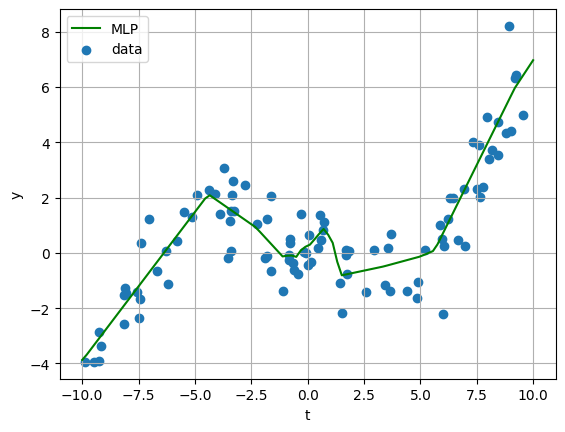

In [19]:
show_preds(f_mlp, 'MLP', nonlinear_data)

In [22]:
f_asym_mlp = models.asymMLP(input_dim=1, output_dim=1, hidden_dim=8, depth=2, task='regression')

trainer = pl.Trainer(max_epochs=100)
trainer.fit(f_asym_mlp, nonlinear_loader, valid_nonlinear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 261.32it/s, v_num=43, val_loss=2.730, valid_acc=nan.0, train_loss=2.660]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 258.99it/s, v_num=43, val_loss=2.730, valid_acc=nan.0, train_loss=2.660]


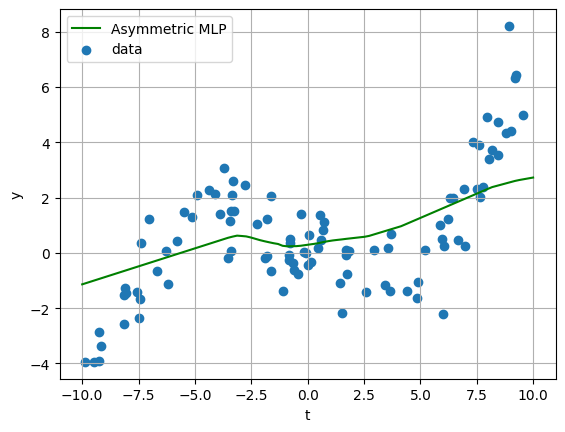

In [23]:
show_preds(f_asym_mlp, 'Asymmetric MLP', nonlinear_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 100/100 [00:01<00:00, 56.93it/s, v_num=45, val_loss=2.760, valid_acc=nan.0, train_loss=2.550] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 100/100 [00:01<00:00, 55.73it/s, v_num=45, val_loss=2.760, valid_acc=nan.0, train_loss=2.550]


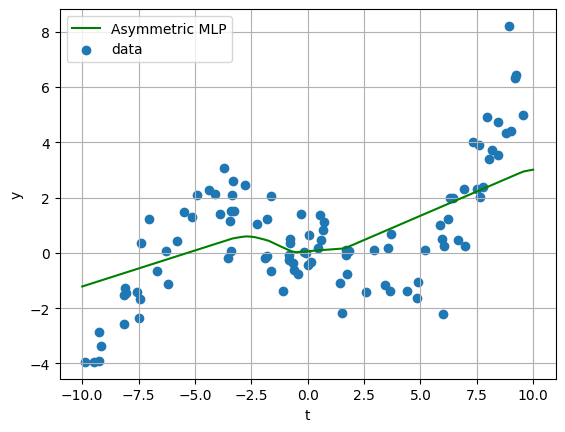

In [25]:
trainer = pl.Trainer(max_epochs=500)
trainer.fit(f_asym_mlp, nonlinear_loader, valid_nonlinear_loader)
show_preds(f_asym_mlp, 'Asymmetric MLP', nonlinear_data)